## Bernstein Vazirani Algorithm  
  
Problem: Given a "secret" $n$-bit string $s$ and an oracle that implements function $f:\{0,1\}^{n}\rightarrow\{0,1\}$ , find $s$.  
Bernstein and Vazirani considered $f(x) = x\cdot s \,\,{\rm mod}\,\, 2 = (\sum\limits_{i=0}^{n-1} x_i s_i)\,\,{\rm mod} \,\,2$

## Classical Solution  
In binary format $s = s_0 s_1 \cdots s_{n-1}$ where $s_i = \{0,1\}$  
By definition
$f(0\cdots01_{i}0\cdots0) = s_{i}$ and with n oracle calls we can determine the "secret" bit string $s$  

$f(1_{0} 0_{1} \cdots 0_{n-1}) = s_{0}$   
$f(0_{0} 1_{1} \cdots 0_{n-1}) = s_{1}$   
$\vdots$   
$f(0_{0} 0_{1} \cdots 1_{n-1}) = s_{n-1}$   

Finding $s$ requires $n$ oracle calls classically

## Quantum Solution  

* Input state $|0\rangle^{\otimes n}$
* Prepare an equal superposition of all possible bit strings $|+\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}}\sum\limits_{x\in\{0,1\}^{n}}|x\rangle$
* Apply a quantum oracle $U_{f(x)}\rightarrow$ $\frac{1}{\sqrt{2^n}}\sum\limits_{x\in\{0,1\}^{n}}(-1)^{f(x)}|x\rangle = \frac{1}{\sqrt{2}}(|0\rangle + (-1)^{s_0}|1\rangle)\otimes\cdots\otimes\frac{1}{\sqrt{2}}(|0\rangle + (-1)^{s_{n-1}}|1\rangle)$
* Apply $n$ Hadamard gates to return to the computational basis
* Read out the final state in the computational basis = the secret string $s$

In [1]:
# general imports
import boto3
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
from datetime import datetime
# import logging
import logging

## Braket SDK imports  

In [2]:
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import LocalSimulator

## Set up Braket simulator 

In [3]:
# set up the device to be the managed simulator
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# set up the device to be the Rigetti quantum computer
# device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")

# set up the device to be the IonQ quantum computer
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# set up the device to be the local simulator
#device = LocalSimulator()

# set up S3 bucket (where results are stored)
# aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
my_bucket = f"amazon-braket-xxx" # f"amazon-braket-{aws_account_id}"the name of the bucket
my_prefix = "bv-output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Define quantum oracle circuit for $U_{f(x)}$

In [22]:
def oracleBV(s):
    ## s is the "secret" string
    nQbts = len(s) + 1
    
    ## initilize the oracle ancila in |->
    oracle_circ = Circuit().ry(nQbts-1,-0.5*np.pi)
    
    ## add a Cx gate between qubit i and ancilla if s_i = 1 
    for ind in range(nQbts-1):
        if s[ind] == '1':
            oracle_circ.cnot(control=ind, target=nQbts-1)
    ## rotate the ancilla qubit back to the Z basis and flip it        
    oracle_circ.h(nQbts-1).x(nQbts-1)
    return oracle_circ

In [17]:
s = '01011'
print (oracleBV(s))

T  : |    0    |1|2|3|4|5|
                          
q1 : -----------C---------
                |         
q3 : -----------|-C-------
                | |       
q4 : -----------|-|-C-----
                | | |     
q5 : -Ry(-1.57)-X-X-X-H-X-

T  : |    0    |1|2|3|4|5|


## Bernstein Vazirani Circuit  

In [18]:
## define the secret string
s = '1101111111'
## Initialize the BV circuit
BV_circuit = Circuit()

for ind in range(len(s)):
    BV_circuit.h(ind)

## Add the oracle to the circuit
BV_circuit.add_circuit(oracleBV(s))

## Rotate back to the computational basis
for ind in range(len(s)):
    BV_circuit.h(ind)

## Print the BV circuit
print(BV_circuit)


T   : |    0    | 1 |2|3|4|5|6|7|8|9|10|11|
                                           
q0  : -H---------C---H---------------------
                 |                         
q1  : -H---------|---C-H-------------------
                 |   |                     
q2  : -H---------|-H-|---------------------
                 |   |                     
q3  : -H---------|---|-C-H-----------------
                 |   | |                   
q4  : -H---------|---|-|-C-H---------------
                 |   | | |                 
q5  : -H---------|---|-|-|-C-H-------------
                 |   | | | |               
q6  : -H---------|---|-|-|-|-C-H-----------
                 |   | | | | |             
q7  : -H---------|---|-|-|-|-|-C-H---------
                 |   | | | | | |           
q8  : -H---------|---|-|-|-|-|-|-C-H-------
                 |   | | | | | | |         
q9  : -H---------|---|-|-|-|-|-|-|-C-H-----
                 |   | | | | | | | |       
q10 : -Ry(-1.57)-X---X-X-X-X-X-X

## Set up SV1 backend  

In [15]:
# set up the device to be the managed simulator
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

Counter({'11011111110': 100})


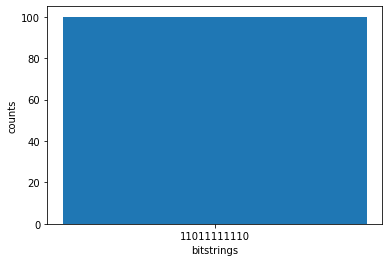

In [16]:
## Create a quantum task to run the BV circuit
task_BV = device.run(BV_circuit, s3_folder, shots=100)

## Get results of task
results = task_BV.result()

## Get measurement counts
counts = results.measurement_counts

# print counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Set up IonQ backend   

In [23]:
# set up the device to be the IonQ quantum computer
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

Counter({'11011111110': 99, '11001111110': 1})


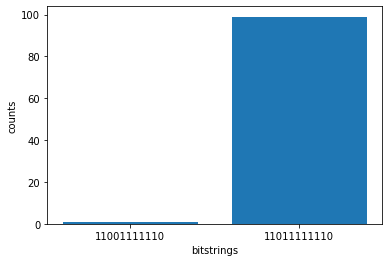

In [24]:
## Create a quantum task to run the BV circuit on IonQ
ionq_task_BV = device.run(BV_circuit, s3_folder, shots=100)

## Get results of task
ionq_results = ionq_task_BV.result()

## Get measurement counts
ionq_counts = ionq_results.measurement_counts

# print counts
print(ionq_counts)

# plot using Counter
plt.bar(ionq_counts.keys(), ionq_counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Set up Rigetti backend  

In [12]:
# set up the device to be the Rigetti quantum computer
device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")

Counter({'00001101011': 2, '00001111101': 2, '00000011001': 2, '00011100101': 2, '10101100101': 2, '10111101110': 2, '00001001000': 1, '00110101100': 1, '11101000010': 1, '10010010011': 1, '11110000110': 1, '00100101000': 1, '01111001000': 1, '10111000011': 1, '11011100101': 1, '01101100010': 1, '01100100000': 1, '10110110100': 1, '01011101010': 1, '00000110111': 1, '00111100101': 1, '10100001011': 1, '10101010011': 1, '00001010110': 1, '10111101010': 1, '10100001100': 1, '10101111010': 1, '11011001101': 1, '11110111010': 1, '01001111111': 1, '10110111111': 1, '10001110101': 1, '10110111011': 1, '10111011011': 1, '10111001110': 1, '10001011010': 1, '01000000010': 1, '00010100111': 1, '00010001111': 1, '10110100011': 1, '11100000011': 1, '10101011110': 1, '10111011001': 1, '00000101110': 1, '00010001101': 1, '01001000001': 1, '11101001010': 1, '00011001000': 1, '10010001111': 1, '00100000101': 1, '00000001000': 1, '10110100101': 1, '10100000011': 1, '00011001010': 1, '00010001001': 1, '

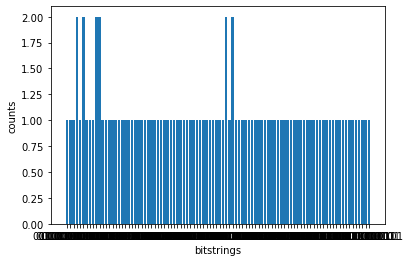

In [13]:
## Create a quantum task to run the BV circuit on Rigetti
rigetti_task_BV = device.run(BV_circuit, s3_folder, shots=100)

## Get results of task
rigetti_results = rigetti_task_BV.result()

## Get measurement counts
rigetti_counts = rigetti_results.measurement_counts

# print counts
print(rigetti_counts)

# plot using Counter
plt.bar(rigetti_counts.keys(), rigetti_counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');